# Plot temperature response over time

## Method: 


## IRF:
Using forcings from RCMIP models and the impulse response function:
\begin{align*}
\text{IRF}(t)=& 0.885\cdot (\frac{0.587}{4.1}\cdot exp(\frac{-t}{4.1}) + \frac{0.413}{249} \cdot exp(\frac{-t}{249}))\\
\text{IRF}(t)= &  \sum_{i=1}^2\frac{\alpha \cdot c_i}{\tau_i}\cdot exp\big(\frac{-t}{\tau_1}\big) 
\end{align*}
with $\alpha = 0.885$, $c_1=0.587$, $\tau_1=4.1$, $c_2=0.413$ and $\tau_2 = 249$.

the estimated ERF$_x$ for some forcing agent $x$ as follows: 

\begin{align*} 
\Delta T (t) &= \int_0^t ERF(t') IRF(t-t') dt' \\
\end{align*}

# Code + figures

## Imports:

import pandas as pd

In [156]:
import xarray as xr
import pandas as pd
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [157]:
from ar6_ch6_rcmipfigs.constants import OUTPUT_DATA_DIR, RESULTS_DIR

PATH_DT = OUTPUT_DATA_DIR + '/dT_data_rcmip_models.nc'

In [158]:
FIGURE_DIR = RESULTS_DIR + '/figures/'

In [159]:

climatemodel = 'climatemodel'
scenario = 'scenario'
variable = 'variable'
time = 'time'

### Define variables to look at:

In [160]:
from ar6_ch6_rcmipfigs.utils.misc_func import new_varname

# variables to plot:
variables_erf_comp = [
    'Effective Radiative Forcing|Anthropogenic|CH4',
    'Effective Radiative Forcing|Anthropogenic|Aerosols',
    'Effective Radiative Forcing|Anthropogenic|Tropospheric Ozone',
    'Effective Radiative Forcing|Anthropogenic|F-Gases|HFC',
    'Effective Radiative Forcing|Anthropogenic|Other|BC on Snow']
# total ERFs for anthropogenic and total:
variables_erf_tot = ['Effective Radiative Forcing|Anthropogenic',
                     'Effective Radiative Forcing']
# Scenarios to plot:
scenarios_fl = ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp370-lowNTCF-aerchemmip',
                # 'ssp370-lowNTCF', Due to mistake here
                'ssp585', 'historical']
scenarios_nhist = ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp370-lowNTCF-aerchemmip',
                'ssp370-lowNTCF-gidden',
                   # 'ssp370-lowNTCF', Due to mistake here
                   'ssp585']  # list(set(scenarios_fl)- {'historical'})
climatemodels_fl = ['Cicero-SCM', 'Cicero-SCM-ECS3', 'FaIR-1.5-DEFAULT', 'MAGICC7.1.0.beta-rcmip-phase-1', 'OSCARv3.0']

# List of delta T for variables
name_deltaT = 'Delta T'
variables_dt_comp = [new_varname(var, name_deltaT) for var in variables_erf_comp]

In [161]:
# Years to plot:
years = ['2040', '2100']

# scn_trans = [trans_scen2plotlabel(label) for label in scenarios_nhist]
# scn_trans = scenarios_nhist  # scenarios except historical

variables_tot = ['Total']
variables_sum = ['Sum SLCFs']


def setup_table_prop(scenario_n='', years=None, variabs=None, scens=None):
    if variabs is None:
        variabs = [var.split('|')[-1] for var in variables_erf_comp]
    if years is None:
        years = ['2040', '2100']
    if scens is None:
        scens = scenarios_nhist
    its = [years, variabs]
    _i = pd.MultiIndex.from_product(its, names=['', ''])
    table = pd.DataFrame(columns=scens, index=_i)  # .transpose()
    table.index.name = scenario_n
    return table

## Open dataset:

### Integrate:
The code below opens the file generated in [2_compute_delta_T.ipynb](2_compute_delta_T.ipynb) by integrating

\begin{align*} 
\Delta T (t) &= \int_0^t ERF(t') IRF(t-t') dt' \\
\end{align*}

where IRF is the impulse response function and ERF is the effective radiative forcing from RCMIP. 

In [162]:
ds_DT = xr.open_dataset(PATH_DT)

## Compute sum of all SLCF forcers

In [163]:
from ar6_ch6_rcmipfigs.utils.plot import get_scenario_c_dic, get_scenario_ls_dic

In [164]:

# ds_DT = dic_ds[0.885]
s_y = '1850'
# cdic = get_scenario_c_dic()

cdic = get_scenario_c_dic()  # get_cmap_dic(ds_DT[scenario].values)
lsdic = get_scenario_ls_dic()  # _scget_ls_dic(ds_DT[climatemodel].values)


def sum_name(var): return '|'.join(var.split('|')[0:2]) + '|' + 'All'


var = variables_erf_comp[0]
f_totn = sum_name(var)
dt_totn = sum_name(new_varname(var, name_deltaT))

# make xarray with variable as new dimension:
_lst_f = []
_lst_dt = []
for var in variables_erf_comp:
    _lst_f.append(ds_DT[var])
    _lst_dt.append(ds_DT[new_varname(var, name_deltaT)])
erf_all = sum_name('Effective Radiative Forcing|Anthropogenic|all')
dt_all = sum_name(new_varname('Effective Radiative Forcing|Anthropogenic|all', name_deltaT))
ds_DT[erf_all] = xr.concat(_lst_f, pd.Index(variables_erf_comp, name='variable'))
ds_DT[dt_all] = xr.concat(_lst_dt, pd.Index(variables_erf_comp, name='variable'))

In [189]:
ref_year = '2021'
scntab_dic = {}


# tab_tot = setup_table2()
# tab_tot_sd = setup_table2()
def table_of_sts(ds_DT, scenarios_nhist, variables, tab_vars, years, ref_year, sts='mean'):
    """
    Creates pandas dataframe of statistics (mean, median, standard deviation) for change
    in temperature Delta T since year (ref year) for each scenario in scenarios,

    :param ds_DT:
    :param scenarios_nhist:
    :param variables:
    :param tab_vars:
    :param years:
    :param ref_year:
    :param sts:
    :return:
    """
    tabel = setup_table_prop(years=years, variabs=tab_vars)
    for scn in scenarios_nhist:
        for var, tabvar in zip(variables, tab_vars):
            dtvar = new_varname(var, name_deltaT) # if ERF name, changes it here.
            tabscn = scn  # Table scenario name the same.
            for year in years:
                _da =ds_DT[dtvar].sel(scenario=scn)
                _da_refy = _da.sel(time=slice(ref_year, ref_year)).squeeze() # ref year value
                _da_y = _da.sel(time=slice(year, year)) # year value
                _tab_da = _da_y - _da_refy
                #_tab_da = ds_DT[dtvar].sel(scenario=scn, time=slice(year, year)) - ds_DT[dtvar].sel(scenario=scn,
                #                                                                                    time=slice(ref_year,
                #                                                                                               ref_year)).squeeze()

                # Do statistics over RCMIP models
                if sts == 'mean':
                    tabel.loc[(year, tabvar), tabscn] = _tab_da.mean('climatemodel').values[0]
                if sts == 'median':
                    tabel.loc[(year, tabvar), tabscn] = _tab_da.median('climatemodel').values[0]
                elif sts == 'std':
                    tabel.loc[(year, tabvar), tabscn] = _tab_da.std('climatemodel').values[0]

    return tabel

def table_of_stats_varsums(ds_DT, scenarios_nhist, dsvar, tabvar, years, ref_year, sts='mean'):
    tabel = setup_table_prop(years=years, variabs=[tabvar])
    da = ds_DT[dsvar]
    if sts=='mean':
        da = ds_DT[dsvar]#.mean('climatemodel').sum('variable')
    if sts == 'median':
        da = ds_DT[dsvar]#.median('climatemodel').sum('variable')
    elif sts=='std':
        da = ds_DT[dsvar]#.sum('variable').std('climatemodel')
    for scn in scenarios_nhist:
        #for var, tabvar in zip(variables, tab_vars):
        dtvar = new_varname(dsvar, name_deltaT) # if ERF name, changes it here.
        tabscn = scn  # Table scenario name the same.
        for year in years:
            _da =da.sel(scenario=scn)
            _da_refy = _da.sel(time=slice(ref_year, ref_year)).squeeze() # ref year value
            _da_y = _da.sel(time=slice(year, year)).squeeze() # year value
            _tab_da = (_da_y - _da_refy).squeeze()
            if sts=='mean':
                _tab_da = _tab_da.mean('climatemodel').sum('variable')
            elif sts == 'median':
                _tab_da = _tab_da.median('climatemodel').sum('variable')
            elif sts=='std':
                _tab_da= _tab_da.sum('variable').std('climatemodel')

            # Do statistics over RCMIP models
            tabel.loc[(year, tabvar), tabscn] = _tab_da.values

    return tabel
        

# Statistics on Delta T anthropogenic
# Mean
tabel_dT_anthrop = table_of_sts(ds_DT, scenarios_nhist, ['Delta T|Anthropogenic'], ['Total'], years, ref_year)
# Standard deviation
tabel_dT_anthrop_SD = table_of_sts(ds_DT, scenarios_nhist, ['Delta T|Anthropogenic'], ['Total'], years, ref_year, sts='std')
# Mean:
tabel_dT_slcfs = table_of_sts(ds_DT, scenarios_nhist, variables_dt_comp, [var.split('|')[-1] for var in variables_dt_comp], years,
                              ref_year)
# Standard deviation
tabel_dT_slcfs_DF = table_of_sts(ds_DT, scenarios_nhist, variables_dt_comp, [var.split('|')[-1] for var in variables_dt_comp],
                                 years, ref_year, sts='std')
# Compute sum of SLCFs
_ds = ds_DT.copy()
vall = 'Delta T|Anthropogenic|All'
_ds[vall] = _ds[vall].sum('variable')
tabel_dT_sum_slcf = table_of_sts(_ds, scenarios_nhist, [vall], ['Sum SLCFs'], years, ref_year)
tabel_dT_sum_slcf_SD = table_of_sts(_ds, scenarios_nhist, [vall], ['Sum SLCFs'], years, ref_year, sts='std')

In [190]:
tabel_dT_sum_slcf_SD

,,ssp119,ssp126,ssp245,ssp370,ssp370-lowNTCF-aerchemmip,ssp370-lowNTCF-gidden,ssp585
,,,,,,,,
2040,Sum SLCFs,0.106843,0.0852915,0.0483122,0.0257856,0.0639803,0.0600776,0.0525353
2100,Sum SLCFs,0.129779,0.140355,0.113588,0.107319,0.168648,0.140443,0.158017


In [191]:
tabel_dT_sum_slcf = table_of_stats_varsums(ds_DT, scenarios_nhist, vall, 'Sum SLCFs', years, ref_year)
tabel_dT_sum_slcf_SD = table_of_stats_varsums(ds_DT, scenarios_nhist, vall, 'Sum SLCFs', years, ref_year, sts='std')
tabel_dT_sum_slcf_SD

,,ssp119,ssp126,ssp245,ssp370,ssp370-lowNTCF-aerchemmip,ssp370-lowNTCF-gidden,ssp585
,,,,,,,,
2040,Sum SLCFs,0.10684343548179748,0.08529145407800068,0.04831220630757891,0.025785552790189827,0.06398027899234776,0.06007755097970012,0.05253533762557518
2100,Sum SLCFs,0.1297791963664601,0.14035522920526422,0.11358809497353772,0.10731891440382212,0.1686480511004645,0.14044266035549746,0.1580167611267991


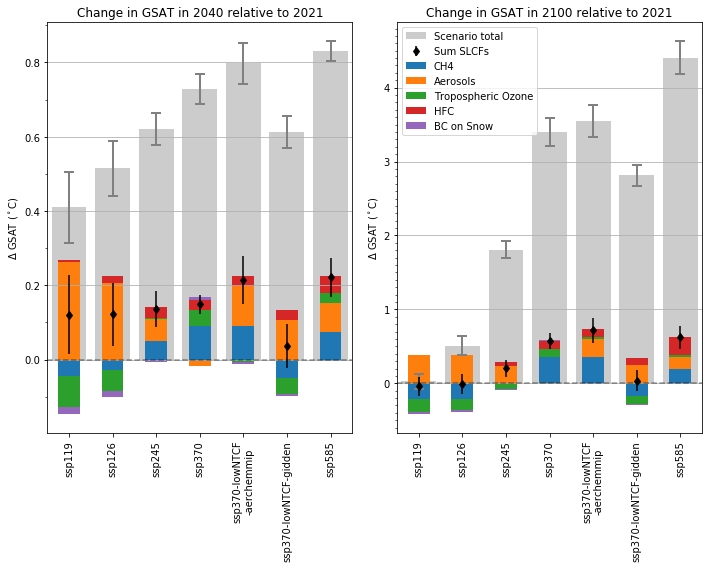

In [192]:
from ar6_ch6_rcmipfigs.constants import RESULTS_DIR
from matplotlib.ticker import (MultipleLocator)
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, len(years), figsize=[10, 8], sharey=False)
tits = ['Near Term surface temperature change (2040 relative to 2021)',
        'Long Term surface T change 2100 relatie to 2021)']
tits = ['Change in GSAT in 2040 relative to 2021', 'Change in GSAT in 2100 relative to 2021']
for yr, ax, tit in zip(years, axs, tits):
    ntot = 'Scenario total'
    tot_yr = tabel_dT_anthrop.loc[yr].rename({'Total': ntot, 'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})
    tot_sd_yr = tabel_dT_anthrop_SD.loc[yr].rename({'Total': ntot, 'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})
    # l =ax.bar(tot_yr.transpose().index, tot_yr.transpose()[ntot].values, color='k', label='Scenario total', alpha=.2, yerr=tab_tot_sd)
    sum_yr = tabel_dT_sum_slcf.loc[yr].rename({'Total': ntot, 'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})
    sum_sd_yr = tabel_dT_sum_slcf_SD.loc[yr].rename(
        {'Total': ntot, 'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})
    ax.bar(tot_yr.transpose().index, tot_yr.transpose()[ntot].values, color='k', label='Scenario total', alpha=.2,
           yerr=tot_sd_yr.transpose()[ntot].values,
           error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2))
    ntot = 'Sum SLCFs'
    # ax.bar(sum_yr.transpose().index, sum_yr.transpose()[ntot].values, color='r', label=ntot, alpha=.2, yerr=sum_sd_yr.transpose()[ntot].values,
    #      error_kw=dict(ecolor='r', lw=2, capsize=0, capthick=1))

    s_x = sum_yr.transpose().index
    s_y = sum_yr.transpose()[ntot].values
    s_err = sum_sd_yr.transpose()[ntot].values
    ax.errorbar(s_x, s_y, color='k', fmt='d', label=ntot, yerr=s_err, linestyle="None")  # ,
    # error_kw=dict(ecolor='r', lw=2, capsize=0, capthick=1))

    _tab = tabel_dT_slcfs.loc[yr].transpose().rename({'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})

    a = _tab.plot(kind='bar', stacked=True, ax=ax, legend=(yr != '2040'))  # , grid=True)#stac)
    if not yr == '2040':
        ax.legend()  # [l],labels=['Sce!!nario total'], loc = 4)#'lower right')

    ax.axhline(0, linestyle='--', color='k', alpha=0.4)
    ax.set_title(tit)
    ax.set_ylabel('$\Delta$ GSAT ($^\circ$C)')
    ax.yaxis.set_minor_locator(MultipleLocator(.1))
    ax.grid(axis='y', which='major')

fn = RESULTS_DIR + '/figures/stack_bar_influence_years.png'
plt.tight_layout()
ax = plt.gca()

ax.tick_params(axis='y', which='minor')  # ,bottom='off')
plt.savefig(fn, dpi=300)

## Error bars only from model uncertainty
The following uncertainties assume the ECS has a standard deviation of

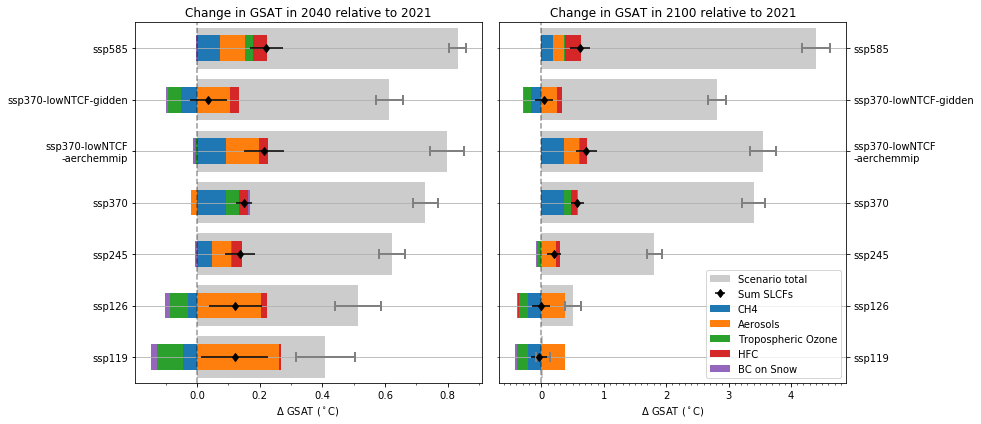

In [193]:
from ar6_ch6_rcmipfigs.constants import RESULTS_DIR
from matplotlib.ticker import (MultipleLocator)
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, len(years), figsize=[12, 6], sharex=False, sharey=True)
tits = ['Near Term surface temperature change (2040 relative to 2021)',
        'Long Term surface T change 2100 relatie to 2021)']
tits = ['Change in GSAT in 2040 relative to 2021', 'Change in GSAT in 2100 relative to 2021']
for yr, ax, tit in zip(years, axs, tits):
    ntot = 'Scenario total'
    # Pick out year and do various renames:
    # Total antropogenic
    tot_yr = tabel_dT_anthrop.loc[yr].rename({'Total': ntot, 'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})
    tot_sd_yr = tabel_dT_anthrop_SD.loc[yr].rename({'Total': ntot, 'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})
    # Sum SLCFs
    sum_yr = tabel_dT_sum_slcf.loc[yr].rename({'Total': ntot, 'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})
    sum_sd_yr = tabel_dT_sum_slcf_SD.loc[yr].rename(
        {'Total': ntot, 'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})
    # Plot bars for anthropopogenic total:
    ax.barh(tot_yr.transpose().index, tot_yr.transpose()[ntot].values, color='k', label='Scenario total', alpha=.2,
            xerr=tot_sd_yr.transpose()[ntot].values,
            error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2))
    # Plot bars for SLCFs total:
    ntot = 'Sum SLCFs'
    s_x = sum_yr.transpose().index
    s_y = sum_yr.transpose()[ntot].values
    s_err = sum_sd_yr.transpose()[ntot].values
    ax.errorbar(s_y, s_x, xerr=s_err, label=ntot, color='k', fmt='d', linestyle="None")  # ,

    # Plot stacked plot of components:
    _tab = tabel_dT_slcfs.loc[yr].transpose().rename({'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})

    a = _tab.plot(kind='barh', stacked=True, ax=ax, legend=(yr != '2040'))  # , grid=True)#stac)
    if not yr == '2040':
        ax.legend()  # [l],labels=['Sce!!nario total'], loc = 4)#'lower right')
    # Zero line:
    ax.axvline(0, linestyle='--', color='k', alpha=0.4)
    ax.set_title(tit)
    ax.set_xlabel('$\Delta$ GSAT ($^\circ$C)')
    ax.xaxis.set_minor_locator(MultipleLocator(.1))
    ax.grid(axis='y', which='major')

fn = RESULTS_DIR + '/figures/stack_bar_influence_years.png'
plt.tight_layout()
ax = plt.gca()

ax.tick_params(axis='y', which='minor')  # ,bottom='off')
ax.tick_params(labelright=True, right=True, left=False)
plt.savefig(fn, dpi=300)

## Error bars from model uncertainty AND ECS uncertainty

See [Uncertainty_calculation.ipynb](Uncertainty_calculation.ipynb)

In [194]:
def sigma_DT(dT, sig_alpha, mu_alpha, dim='climatemodel'):
    sig_DT = dT.std(dim)
    mu_DT = dT.mean(dim)
    return ((sig_DT + mu_DT) * (sig_alpha + mu_alpha) - mu_DT * mu_alpha) / mu_alpha


def sigma_com(sig_DT, mu_DT, sig_alpha, mu_alpha):
    return (((sig_DT ** 2 + mu_DT ** 2) * (
            sig_alpha ** 2 + mu_alpha ** 2) - mu_DT ** 2 * mu_alpha ** 2) / mu_alpha ** 2) ** .5


sum_DT_std =  table_of_sts(_ds, scenarios_nhist, [vall], ['Sum SLCFs'], years, ref_year, sts='std')
sum_DT_mean = table_of_sts(_ds, scenarios_nhist, [vall], ['Sum SLCFs'], years, ref_year, sts='mean')
tot_DT_std = table_of_sts(ds_DT, scenarios_nhist, ['Delta T|Anthropogenic'], ['Total'], years, ref_year, sts='std')
tot_DT_mean = table_of_sts(ds_DT, scenarios_nhist, ['Delta T|Anthropogenic'], ['Total'], years, ref_year, sts='mean')

yerr_sum = sigma_com(sum_DT_std, sum_DT_mean, .24, .885)
yerr_tot = sigma_com(tot_DT_std, tot_DT_mean, .24, .885)  # .rename('')

# tab_sig_DT = setup_table_prop()

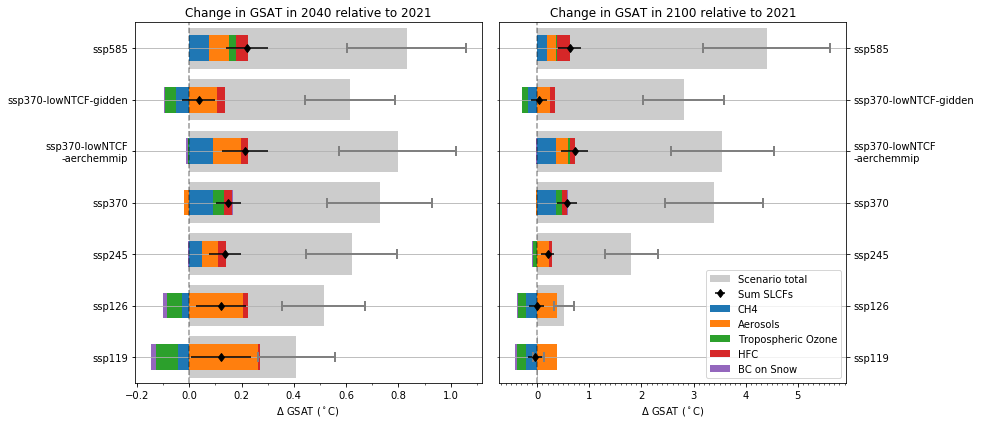

In [195]:
from ar6_ch6_rcmipfigs.constants import RESULTS_DIR
from matplotlib.ticker import (MultipleLocator)
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, len(years), figsize=[12, 6], sharex=False, sharey=True)
tits = ['Near Term surface temperature change (2040 relative to 2021)',
        'Long Term surface T change 2100 relatie to 2021)']
tits = ['Change in GSAT in 2040 relative to 2021', 'Change in GSAT in 2100 relative to 2021']
for yr, ax, tit in zip(years, axs, tits):
    ntot = 'Scenario total'
    tot_yr = tabel_dT_anthrop.loc[yr].rename({'Total': ntot, 'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})
    tot_sd_yr = yerr_tot.loc[yr].rename({'Total': ntot, 'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})
    # l =ax.bar(tot_yr.transpose().index, tot_yr.transpose()[ntot].values, color='k', label='Scenario total', alpha=.2, yerr=tab_tot_sd)
    sum_yr = tabel_dT_sum_slcf.loc[yr].rename({'Total': ntot, 'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})
    sum_sd_yr = yerr_sum.loc[yr].rename({'Total': ntot, 'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})
    ax.barh(tot_yr.transpose().index, tot_yr.transpose()[ntot].values, color='k', label='Scenario total', alpha=.2,
            xerr=tot_sd_yr.transpose()[ntot].values,
            error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2))
    ntot = 'Sum SLCFs'
    # ax.bar(sum_yr.transpose().index, sum_yr.transpose()[ntot].values, color='r', label=ntot, alpha=.2, yerr=sum_sd_yr.transpose()[ntot].values,
    #      error_kw=dict(ecolor='r', lw=2, capsize=0, capthick=1))

    s_x = sum_yr.transpose().index
    s_y = sum_yr.transpose()[ntot].values
    s_err = sum_sd_yr.transpose()[ntot].values
    ax.errorbar(s_y, s_x, xerr=s_err, label=ntot, color='k', fmt='d', linestyle="None")  # ,
    # error_kw=dict(ecolor='r', lw=2, capsize=0, capthick=1))

    _tab = tabel_dT_slcfs.loc[yr].transpose().rename({'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})

    a = _tab.plot(kind='barh', stacked=True, ax=ax, legend=(yr != '2040'))  # , grid=True)#stac)
    if not yr == '2040':
        ax.legend()  # [l],labels=['Sce!!nario total'], loc = 4)#'lower right')

    ax.axvline(0, linestyle='--', color='k', alpha=0.4)
    ax.set_title(tit)
    ax.set_xlabel('$\Delta$ GSAT ($^\circ$C)')
    ax.xaxis.set_minor_locator(MultipleLocator(.1))
    ax.grid(axis='y', which='major')

fn = RESULTS_DIR + '/figures/stack_bar_influence_years_horiz_errTot.png'
plt.tight_layout()
ax = plt.gca()

ax.tick_params(axis='y', which='minor')  # ,bottom='off')
ax.tick_params(labelright=True, right=True, left=False)
plt.savefig(fn, dpi=300)

## Only ssp370:

In [196]:
scenario_370 =[sc for sc in scenarios_nhist if 'ssp370' in sc]

In [197]:
tabel_dT_anthrop.loc[yr,scenario_370]

,ssp370,ssp370-lowNTCF-aerchemmip,ssp370-lowNTCF-gidden
,,,
Total,3.39964,3.54998,2.81364


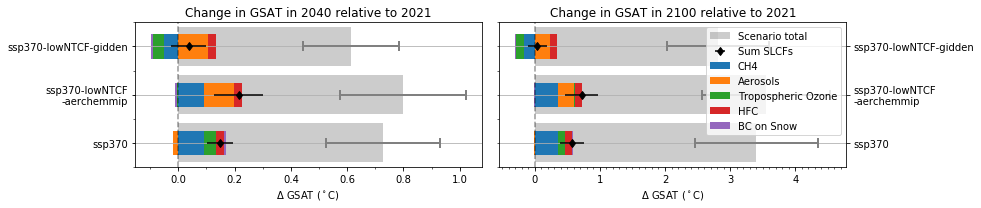

In [198]:
from ar6_ch6_rcmipfigs.constants import RESULTS_DIR
from matplotlib.ticker import (MultipleLocator)
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, len(years), figsize=[12, 3], sharex=False, sharey=True)
tits = ['Near Term surface temperature change (2040 relative to 2021)',
        'Long Term surface T change 2100 relatie to 2021)']
tits = ['Change in GSAT in 2040 relative to 2021', 'Change in GSAT in 2100 relative to 2021']
for yr, ax, tit in zip(years, axs, tits):
    ntot = 'Scenario total'
    tot_yr = tabel_dT_anthrop.loc[yr, scenario_370].rename({'Total': ntot, 'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})
    tot_sd_yr = yerr_tot.loc[yr, scenario_370].rename({'Total': ntot, 'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})
    # l =ax.bar(tot_yr.transpose().index, tot_yr.transpose()[ntot].values, color='k', label='Scenario total', alpha=.2, yerr=tab_tot_sd)
    sum_yr = tabel_dT_sum_slcf.loc[yr, scenario_370].rename({'Total': ntot, 'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})
    sum_sd_yr = yerr_sum.loc[yr, scenario_370].rename({'Total': ntot, 'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})
    
    ax.barh(tot_yr.transpose().index, tot_yr.transpose()[ntot].values, color='k', label='Scenario total', alpha=.2,
            xerr=tot_sd_yr.transpose()[ntot].values,
            error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2))
    ntot = 'Sum SLCFs'
    # ax.bar(sum_yr.transpose().index, sum_yr.transpose()[ntot].values, color='r', label=ntot, alpha=.2, yerr=sum_sd_yr.transpose()[ntot].values,
    #      error_kw=dict(ecolor='r', lw=2, capsize=0, capthick=1))

    s_x = sum_yr.transpose().index
    s_y = sum_yr.transpose()[ntot].values
    s_err = sum_sd_yr.transpose()[ntot].values
    ax.errorbar(s_y, s_x, xerr=s_err, label=ntot, color='k', fmt='d', linestyle="None")  # ,
    # error_kw=dict(ecolor='r', lw=2, capsize=0, capthick=1))

    _tab = tabel_dT_slcfs.loc[yr, scenario_370].transpose().rename({'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})

    a = _tab.plot(kind='barh', stacked=True, ax=ax, legend=(yr != '2040'))  # , grid=True)#stac)
    if not yr == '2040':
        ax.legend()  # [l],labels=['Sce!!nario total'], loc = 4)#'lower right')

    ax.axvline(0, linestyle='--', color='k', alpha=0.4)
    ax.set_title(tit)
    ax.set_xlabel('$\Delta$ GSAT ($^\circ$C)')
    ax.xaxis.set_minor_locator(MultipleLocator(.1))
    ax.grid(axis='y', which='major')

fn = RESULTS_DIR + '/figures/stack_bar_influence_years_horiz_errTot_370only.png'
plt.tight_layout()
ax = plt.gca()

ax.tick_params(axis='y', which='minor')  # ,bottom='off')
ax.tick_params(labelright=True, right=True, left=False)
plt.savefig(fn, dpi=300)
a=2
#plt.show()

# prosent of total:



In [199]:
tabel_dT_anthrop

,,ssp119,ssp126,ssp245,ssp370,ssp370-lowNTCF-aerchemmip,ssp370-lowNTCF-gidden,ssp585
,,,,,,,,
2040,Total,0.409698,0.514518,0.621916,0.728237,0.798053,0.613612,0.831031
2100,Total,0.0245512,0.510912,1.80734,3.39964,3.54998,2.81364,4.40707


In [200]:
tabel_dT_slcfs

ssp119      ssp126      ssp245      ssp370  \
                                                                          
2040 CH4                 -0.0447013  -0.0291883   0.0486324   0.0917135   
     Aerosols              0.262955    0.205296   0.0611389  -0.0186025   
     Tropospheric Ozone  -0.0839045   -0.056743  0.00156772   0.0413476   
     HFC                 0.00582878   0.0185408   0.0306454   0.0286523   
     BC on Snow          -0.0190398  -0.0158591 -0.00571875  0.00619175   
2100 CH4                   -0.21796   -0.206977 -0.00702949    0.362437   
     Aerosols              0.378002    0.382743    0.229839  -0.0124726   
     Tropospheric Ozone   -0.168869   -0.158057   -0.065602    0.106714   
     HFC                -0.00500177 -0.00222552   0.0646217    0.109127   
     BC on Snow          -0.0285351  -0.0257577  -0.0209888   0.0113509   

                        ssp370-lowNTCF-aerchemmip ssp370-lowNTCF-gidden  \
                                                                          
2040 CH4                                0.0917135            -0.0505624   
     Aerosols                            0.105429              0.106122   
     Tropospheric Ozone               -0.00538849            -0.0412995   
     HFC                                0.0286523             0.0286542   
     BC on Snow                       -0.00629107           -0.00637372   
2100 CH4                                 0.362437             -0.170351   
     Aerosols                            0.239401              0.242435   
     Tropospheric Ozone                 0.0202453              -0.11613   
     HFC                                 0.109127             0.0942153   
     BC on Snow                        -0.0118344            -0.0126836   

                             ssp585  
                                     
2040 CH4                  0.0741541  
     Aerosols             0.0791586  
     Tropospheric Ozone   0.0257412  
     HFC                  0.0455577  
     BC on Snow         -0.00305192  
2100 CH4                   0.193089  
     Aerosols              0.164572  
     Tropospheric Ozone   0.0191433  
     HFC                   0.251827  
     BC on Snow         -0.00593702

In [201]:
tabel_dT_sum_slcf

,,ssp119,ssp126,ssp245,ssp370,ssp370-lowNTCF-aerchemmip,ssp370-lowNTCF-gidden,ssp585
,,,,,,,,
2040,Sum SLCFs,0.12113768163025361,0.12204675645646818,0.13626564724821078,0.14930274397448162,0.21411576918531927,0.036540477925460564,0.22155965866487787
2100,Sum SLCFs,-0.04236441172655865,-0.010273078419766678,0.20084007345336521,0.5771562749011422,0.7193754374814196,0.03748543344928557,0.6226940927425837


In [202]:
slcf_pct_tot

,,ssp119,ssp126,ssp245,ssp370,ssp370-lowNTCF-aerchemmip,ssp370-lowNTCF-gidden,ssp585
,,,,,,,,
2040,Total SLCFs,29.5675,23.7206,21.9106,20.502,26.8298,5.95498,26.6608
2100,Total SLCFs,-172.556,-2.01073,11.1125,16.977,20.2642,1.33227,14.1294


In [203]:
vn_slct_tot = 'Total SLCFs'
slcf_pct_tot = setup_table_prop(variabs=[vn_slct_tot])
comp_pct_totslcf = setup_table_prop()
for yr in years:
        slc_sum = tabel_dT_sum_slcf.loc[(yr, 'Sum SLCFs')]
        tot = tabel_dT_anthrop.loc[(yr, 'Total')] 
        slcf_pct_tot.loc[(yr, vn_slct_tot)] = (slc_sum)/tot*100
        
        # comp_pct_tot:
        for scn in scenarios_nhist:
            slcf = tabel_dT_slcfs.loc[(yr)][scn]
            comp_pct_totslcf.loc[yr, scn] = slcf.values/tot[scn]*100

In [204]:
tabel_dT_sum_slcf

,,ssp119,ssp126,ssp245,ssp370,ssp370-lowNTCF-aerchemmip,ssp370-lowNTCF-gidden,ssp585
,,,,,,,,
2040,Sum SLCFs,0.12113768163025361,0.12204675645646818,0.13626564724821078,0.14930274397448162,0.21411576918531927,0.036540477925460564,0.22155965866487787
2100,Sum SLCFs,-0.04236441172655865,-0.010273078419766678,0.20084007345336521,0.5771562749011422,0.7193754374814196,0.03748543344928557,0.6226940927425837


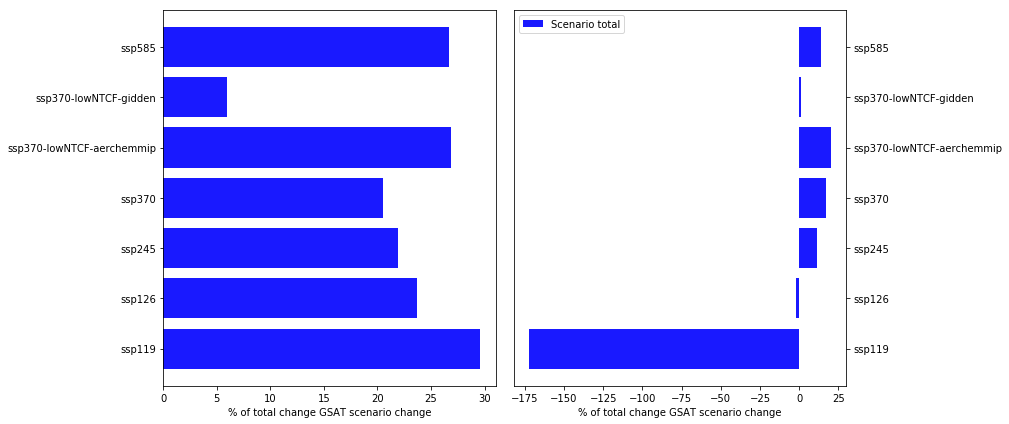

In [213]:
from ar6_ch6_rcmipfigs.constants import RESULTS_DIR
from matplotlib.ticker import (MultipleLocator)
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, len(years), figsize=[12, 6], sharex=False, sharey=True)
tits = ['Near Term surface temperature change (2040 relative to 2021)',
        'Long Term surface T change 2100 relatie to 2021)']
tits = ['Change in GSAT in 2040 relative to 2021', 'Change in GSAT in 2100 relative to 2021']
for yr, ax, tit in zip(years, axs, tits):
    ntot = 'Scenario total'
    #tot_yr = tabel_dT_anthrop.loc[yr].rename({'Total': ntot, 'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})
    #tot_sd_yr = yerr_tot.loc[yr].rename({'Total': ntot, 'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})
    
    sum_yr_pcd = slcf_pct_tot.loc[yr].rename({'Total SLCFs': ntot, 'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})
    #sum_sd_yr = yerr_sum.loc[yr].rename({'Total': ntot, 'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})
    ax.barh(sum_yr_pcd.transpose().index, sum_yr_pcd.transpose()[ntot].values, color='blue', label='Scenario total', alpha=.9,
            #xerr=tot_sd_yr.transpose()[ntot].values,
            error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2))
    ntot = 'Sum SLCFs'
    # ax.bar(sum_yr.transpose().index, sum_yr.transpose()[ntot].values, color='r', label=ntot, alpha=.2, yerr=sum_sd_yr.transpose()[ntot].values,
    #      error_kw=dict(ecolor='r', lw=2, capsize=0, capthick=1))

    #s_x = sum_yr.transpose().index
    #s_y = sum_yr.transpose()[ntot].values
    #s_err = sum_sd_yr.transpose()[ntot].values
    #ax.errorbar(s_y, s_x, xerr=s_err, label=ntot, color='k', fmt='d', linestyle="None")  # ,
    # error_kw=dict(ecolor='r', lw=2, capsize=0, capthick=1))

    _tab = comp_pct_totslcf.loc[yr].transpose().rename({'ssp370-lowNTCF-aerchemmip': 'ssp370-lowNTCF\n-aerchemmip'})

    #a = _tab.plot(kind='barh', stacked=True, ax=ax, legend=(yr != '2040'))  # , grid=True)#stac)
    if not yr == '2040':
        ax.legend()  # [l],labels=['Sce!!nario total'], loc = 4)#'lower right')

    #ax.axvline(0, linestyle='--', color='k', alpha=0.4)
    #ax.set_title(tit)
    ax.set_xlabel('% of total change GSAT scenario change')
    #ax.xaxis.set_minor_locator(MultipleLocator(.1))
    #ax.grid(axis='y', which='major')

fn = RESULTS_DIR + '/figures/stack_bar_influence_years_horiz_errTot.png'
plt.tight_layout()
ax = plt.gca()

ax.tick_params(axis='y', which='minor')  # ,bottom='off')
ax.tick_params(labelright=True, right=True, left=False)
plt.savefig(fn, dpi=300)

In [186]:
plt.show()

- De vi allerede har.

Hvis vi skulle lagt til usikkerhet?
- Ville lagt til usikkerhet gjennom ECS -- 
    - Regne ut de samme tallene for 3 verdier av ECS. 
    - Monte carlo trekk med en fordeling på ECS. 
    - 